# Analyzing 2021 Citibike Data

As part of our project, "Analyzing the Relationships between Car Accidents and Public Transportation in NYC," we decided to look at CitiBike's data to see if we see any relationship between where the most used CitiBike stations are located and the prevalence of motor vehicle accidents within the vicinity of the station. 

### Questions to Ask 

- Where do Citibikers ride to?
- When do they ride? What days/hours/months are the most popular for usage?
- How far do Citibikes go?
- Which stations are the most popular?

### Process Outline

- Merge CitiBike monthly files into csv files grouped by year for easier manipulation
- Conduct Seasonality Analysis for ridership
- Conduct Demographic Analysis for ridership
- Conduct Spatial Analysis to see which stations are the most popular

## Prepare the Data 

In [1]:
#import required libraries
import numpy                 as np
import pandas                as pd
import glob
import matplotlib.pyplot     as plt
import seaborn               as sns
import folium  #needed for interactive map
from folium.plugins import HeatMap
from datetime import datetime
%matplotlib inline
sns.set()

#read and import Jan 2021 dataframe and rename columns to match the columns in the other 2021 Citibike data
frame = pd.read_csv(r'C:\Users\nicol\Documents\DS4A\Group Project\Citibike Data\202101-citibike-tripdata.csv')
frame = frame.rename(columns={'starttime':'started_at',
                              'stoptime':'ended_at',
                              'start station id':'start_station_id',
                              'start station name':'start_station_name',
                              'start station latitude':'start_lat',
                              'start station longitude':'start_lng',
                              'end station id':'end_station_id',
                              'end station name':'end_station_name',
                              'end station latitude':'end_lat',
                              'end station longitude':'end_lng'
                              })

#drop the columns not in the other 2021 Citibike data
frame = frame.drop(['usertype','birth year','gender'], 1)
frame.sample(10)

,tripduration,started_at,ended_at,start_station_id,start_station_name,start_lat,start_lng,end_station_id,end_station_name,end_lat,end_lng,bikeid
858154,1013,2021-01-23 22:25:04.6630,2021-01-23 22:41:58.5730,3301,Columbus Ave & W 95 St,40.791956,-73.968087,3699,W 50 St & 9 Ave,40.763605,-73.989180,45428
1041336,1803,2021-01-29 18:11:15.7150,2021-01-29 18:41:18.9020,519,Pershing Square North,40.751873,-73.977706,539,Metropolitan Ave & Bedford Ave,40.715348,-73.960241,49982
740031,82,2021-01-20 21:00:25.3760,2021-01-20 21:01:47.5760,3141,1 Ave & E 68 St,40.765005,-73.958185,3141,1 Ave & E 68 St,40.765005,-73.958185,33580
88810,3673,2021-01-04 13:12:38.0700,2021-01-04 14:13:51.3310,3293,W 92 St & Broadway,40.792100,-73.973900,281,Grand Army Plaza & Central Park S,40.764397,-73.973715,34076
695080,206,2021-01-19 17:47:04.5490,2021-01-19 17:50:31.0150,3809,W 55 St & 6 Ave,40.763189,-73.978434,457,Broadway & W 58 St,40.766953,-73.981693,42476
242171,2280,2021-01-08 14:00:42.6780,2021-01-08 14:38:42.7620,3830,Halsey St & Evergreen Ave,40.688580,-73.912270,168,W 18 St & 6 Ave,40.739713,-73.994564,49722
778744,857,2021-01-21 19:56:40.8860,2021-01-21 20:10:58.1430,3727,Frost St & Meeker Ave,40.717662,-73.948800,3080,S 4 St & Rodney St,40.709340,-73.956080,47993
1014529,389,2021-01-28 17:36:13.1540,2021-01-28 17:42:42.6130,3699,W 50 St & 9 Ave,40.763605,-73.989180,4044,8 Ave & W 38 St,40.754610,-73.991770,30989
371246,249,2021-01-12 07:09:27.8230,2021-01-12 07:13:37.3250,82,St James Pl & Pearl St,40.711174,-74.000165,387,Centre St & Chambers St,40.712733,-74.004607,34203
933509,143,2021-01-26 10:59:52.2790,2021-01-26 11:02:15.9900,3848,Suydam St & Broadway,40.695440,-73.932230,3838,Bushwick Ave & Harman St,40.693560,-73.925240,49086


In [2]:
#import and concentate Feb thru Dec 2021 monthly citibike excel files

path = r'C:\Users\nicol\Documents\DS4A\Group Project\Citibike Data\2021'
all_files = glob.glob(path + "/*.csv")

li = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)

df = pd.concat(li, axis=0, ignore_index=True)
df.sample(10)

C:\Users\nicol\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (5,7) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
C:\Users\nicol\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
25697110,59790AAA4D214D68,classic_bike,2021-12-19 13:40:13,2021-12-19 13:57:50,W 67 St & Broadway,7116.04,E 89 St & 3 Ave,7265.1,40.774925,-73.982666,40.780628,-73.952167,member
25919238,C6661AAA8F2138BC,classic_bike,2021-12-03 18:19:18,2021-12-03 18:24:10,Riverside Dr & W 82 St,7388.10,Riverside Blvd & W 67 St,7183.03,40.787209,-73.981281,40.777507,-73.988886,member
19034835,DD810AFB59A56441,classic_bike,2021-09-08 17:40:36,2021-09-08 17:47:46,Amsterdam Ave & W 73 St,7260.09,W 84 St & Broadway,7409.08,40.779668,-73.980930,40.786795,-73.977112,member
7307051,B385D2D6F3FE29CE,docked_bike,2021-06-16 12:04:31,2021-06-16 12:29:39,Lispenard St & Broadway,5391.06,6 Ave & W 33 St,6364.07,40.719392,-74.002472,40.749013,-73.988484,member
12401602,8951C8F13AA5028C,classic_bike,2021-07-24 19:49:15,2021-07-24 19:53:56,E 7 St & Avenue A,5626.07,Broadway & E 14 St,5905.12,40.726218,-73.983799,40.734546,-73.990741,member
839674,40E778DF5E9C8F45,docked_bike,2021-03-15 15:02:21,2021-03-15 15:02:59,Tompkins Ave & Hopkins St,4850.04,Tompkins Ave & Hopkins St,4850.04,40.699576,-73.947084,40.699576,-73.947084,member
7345409,D35718E99DFDBCC8,docked_bike,2021-06-20 17:59:55,2021-06-20 18:13:41,35 St & 30 Ave,6887.03,Queens Plaza North & Crescent St,6429.01,40.765475,-73.918115,40.751102,-73.940737,member
20718598,4DB95A69CAF96F07,classic_bike,2021-10-29 12:49:00,2021-10-29 13:06:03,Albany St & Greenwich St,5145.02,E 2 St & 2 Ave,5593.02,40.709267,-74.013247,40.725029,-73.990697,member
26283581,0EDA1B908BCBF2F4,classic_bike,2021-12-02 10:58:07,2021-12-02 11:05:57,E 33 St & 5 Ave,6322.01,W 13 St & 5 Ave,5947.04,40.747659,-73.984907,40.735445,-73.994310,member
21129152,2C1C2D840F170D9E,classic_bike,2021-10-13 07:40:06,2021-10-13 07:44:43,W 33 St & 7 Ave,6407.07,Madison Ave & E 26 St,6131.12,40.750200,-73.990931,40.742685,-73.986713,member


In [3]:
#examine the data types of the Jan 2021 dataset
frame.dtypes

tripduration            int64
started_at             object
ended_at               object
start_station_id        int64
start_station_name     object
start_lat             float64
start_lng             float64
end_station_id          int64
end_station_name       object
end_lat               float64
end_lng               float64
bikeid                  int64
dtype: object

In [4]:
#convert columns to correct datatypes in Jan 2021 dataset
frame['start_station_name'] = frame['start_station_name'].astype('category')
frame['start_station_id'] = frame['start_station_id'].astype('category')
frame['end_station_id'] = frame['end_station_id'].astype('category')
frame['end_station_name'] = frame['end_station_name'].astype('category')

#convert the started_at and ended_at columns to datetime in Jan 2021 dataset
frame['started_at'] = pd.to_datetime(frame['started_at'])
frame['ended_at'] = pd.to_datetime(frame['ended_at'])

In [5]:
df.dtypes

ride_id                object
rideable_type          object
started_at             object
ended_at               object
start_station_name     object
start_station_id       object
end_station_name       object
end_station_id         object
start_lat             float64
start_lng             float64
end_lat               float64
end_lng               float64
member_casual          object
dtype: object

In [6]:
#convert columns to correct datatypes in the concatenated Feb - Dec 2021 Citibike data
df['start_station_name'] = df['start_station_name'].astype('category')
df['start_station_id'] = df['start_station_id'].astype('category')
df['end_station_id'] = df['end_station_id'].astype('category')
df['end_station_name'] = df['end_station_name'].astype('category')

#convert the started_at and ended_at columns to datetime in the concatenated Feb - Dec 2021 Citibike data
df['started_at'] = pd.to_datetime(df['started_at'])
df['ended_at'] = pd.to_datetime(df['ended_at'])

#drop unnecessary columns in the concatenated Feb - Dec 2021 Citibike data
df = df.drop(['rideable_type','member_casual'], 1)

In [7]:
#concatenante the Jan 2021 Citibike and Feb - Dec 2021 Citibike datasets
combined_df = df = pd.concat([frame,df], axis=0, ignore_index=True)
combined_df.sample(10)

,tripduration,started_at,ended_at,start_station_id,start_station_name,start_lat,start_lng,end_station_id,end_station_name,end_lat,end_lng,bikeid,ride_id
17683516,NaN,2021-09-19 18:55:19,2021-09-19 19:19:33,5190.07,Madison St & Clinton St,40.712690,-73.987763,5411.07,Union Ave & N 12 St,40.719240,-73.952420,NaN,09EA59C38E3FCBA3
16963317,NaN,2021-08-23 19:54:02,2021-08-23 20:10:42,4996.08,McKibbin St & Manhattan Ave,40.705109,-73.944073,4278.03,Marcus Garvey Blvd & Macon St,40.682601,-73.938037,NaN,BCE150756532FCCF
18714635,NaN,2021-09-30 19:23:58,2021-09-30 19:32:15,6140.05,W 21 St & 6 Ave,40.741740,-73.994156,5922.04,Greenwich St & Perry St,40.734980,-74.006970,NaN,24EE7DE9B9C60192
16803854,NaN,2021-08-05 18:02:13,2021-08-05 18:35:58,7436.11,2 Ave & E 104 St,40.789211,-73.943708,6464.08,E 45 St & 3 Ave,40.752554,-73.972826,NaN,856AAE0EA1434ADF
27211689,NaN,2021-12-02 12:25:05,2021-12-02 12:31:44,5679.08,Bleecker St & Crosby St,40.726156,-73.995102,5430.08,Franklin St & W Broadway,40.719116,-74.006667,NaN,CE9730BA5B5B05E6
23729823,NaN,2021-10-09 17:33:32,2021-10-09 17:47:47,7682.01,Park Ave & E 124 St,40.804555,-73.939686,7915.11,Edgecombe Ave & W 141 St,40.820681,-73.945144,NaN,F04312C9922BAB6F
18414179,NaN,2021-09-11 12:22:02,2021-09-11 12:42:35,6912.01,7 Ave & Central Park South,40.766741,-73.979069,7538.18,Central Park W & W 97 St,40.792495,-73.964171,NaN,025BDD5EA7EA3714
20977140,NaN,2021-10-31 19:23:33,2021-10-31 19:57:18,4748.07,Clinton St & Tillary St,40.696233,-73.991421,5216.06,Vesey St & Church St,40.712220,-74.010472,NaN,6D287C55B4EE1D18
19342684,NaN,2021-09-16 17:15:33,2021-09-16 17:29:49,5470.12,North Moore St & Greenwich St,40.720195,-74.010301,5679.08,Bleecker St & Crosby St,40.726156,-73.995102,NaN,E2C23B70031D52B6
27452387,NaN,2021-12-16 12:48:34,2021-12-16 12:54:44,4157.1,Bergen St & Vanderbilt Ave,40.679439,-73.968044,4051.01,Berkeley Pl & 7 Ave,40.675147,-73.975232,NaN,24A65EA6FA519B65


In [8]:
combined_df.dtypes

tripduration                 float64
started_at            datetime64[ns]
ended_at              datetime64[ns]
start_station_id              object
start_station_name            object
start_lat                    float64
start_lng                    float64
end_station_id                object
end_station_name              object
end_lat                      float64
end_lng                      float64
bikeid                       float64
ride_id                       object
dtype: object

In [9]:
#fill in the NaN values in the tripduration column and convert it into minutes
combined_df['tripduration'] = (combined_df['ended_at'] - combined_df['started_at'])
combined_df['tripduration'] = combined_df['tripduration'].dt.seconds
combined_df['tripduration'] = combined_df['tripduration'] / 60
combined_df.sample(10)

,tripduration,started_at,ended_at,start_station_id,start_station_name,start_lat,start_lng,end_station_id,end_station_name,end_lat,end_lng,bikeid,ride_id
25821180,3.750000,2021-11-30 19:01:01,2021-11-30 19:04:46,4620.02,Adelphi St & Myrtle Ave,40.693083,-73.971789,4762.04,Clinton Ave & Flushing Ave,40.697940,-73.969868,NaN,3CE1672D89DDE356
7950888,2.750000,2021-05-16 10:28:05,2021-05-16 10:30:50,4060.09,Carroll St & 5 Ave,40.675162,-73.981483,4143.04,3 Ave & Carroll St,40.677027,-73.986500,NaN,735EC79DC59B6F17
23939658,3.033333,2021-11-17 16:59:49,2021-11-17 17:02:51,8665.09,Isham St & Broadway,40.867880,-73.919685,8715.06,W 218 St & Broadway,40.871390,-73.914318,NaN,CAAFD6C64DF4488E
13031179,38.866667,2021-07-26 15:28:36,2021-07-26 16:07:28,6140.05,W 21 St & 6 Ave,40.741740,-73.994156,7704.04,Adam Clayton Powell Blvd & W 123 St,40.807832,-73.949373,NaN,D5D0751AE125F3F9
14524092,15.200000,2021-08-01 15:36:57,2021-08-01 15:52:09,6765.01,12 Ave & W 40 St,40.760875,-74.002777,6157.04,10 Ave & W 14 St,40.741982,-74.008316,NaN,A404C28C02FAD570
25485515,13.800000,2021-11-10 09:19:34,2021-11-10 09:33:22,5626.07,E 7 St & Avenue A,40.726218,-73.983799,6257.03,W 24 St & 7 Ave,40.744876,-73.995299,NaN,F920D12C5EBB3D2A
10072936,3.683333,2021-06-05 08:59:32,2021-06-05 09:03:13,7738.04,Adam Clayton Powell Blvd & W 126 St,40.809495,-73.947764,7800.03,Amsterdam Ave & W 125 St,40.813358,-73.956461,NaN,6DB711E0CD14B9B1
22097165,7.933333,2021-10-17 01:43:34,2021-10-17 01:51:30,5820.08,E 13 St & 2 Ave,40.731539,-73.985302,5342.10,Allen St & Hester St,40.716059,-73.991908,NaN,9CBBBDDB1886613A
24523655,32.566667,2021-11-09 17:14:28,2021-11-09 17:47:02,5207.01,Centre St & Chambers St,40.712733,-74.004607,4051.01,Berkeley Pl & 7 Ave,40.675147,-73.975232,NaN,599301BFB25E4F59
7143217,6.233333,2021-05-16 18:21:40,2021-05-16 18:27:54,7538.14,W 100 St & Manhattan Ave,40.795000,-73.964500,7511.19,5 Ave & E 103 St,40.792255,-73.952499,NaN,D9FA78415A71F59A


In [10]:
combined_df['started_at_month'] = combined_df['started_at'].dt.month
combined_df['started_at_weekday'] = combined_df['started_at'].dt.weekday
combined_df['started_at_hour'] = combined_df['started_at'].dt.hour

## Seasonal Trend Analysis

Aim to see if there are any trends in seasonality.

In [11]:
#create groupby object for rides by month
monthly_rides = combined_df.groupby(['started_at_month']).size()

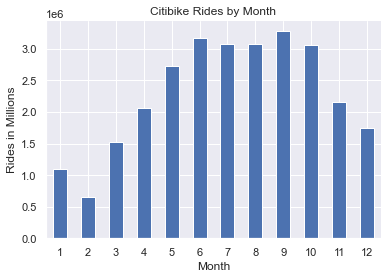

In [12]:
ax = monthly_rides.plot(kind='bar', 
                   title='Citibike Rides by Month', 
                   rot=0)

ax.set_xlabel("Month")
ax.set_ylabel("Rides in Millions")

#hide top and right spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

The months with the lowest ridership on Citibike the winter months: January and February. Peak months of ridership are June and September, whcih makes sense since the weather is warmer. 

In [13]:
##create groupby object for rides by weekday
weekday_rides = combined_df.groupby(['started_at_weekday']).size()

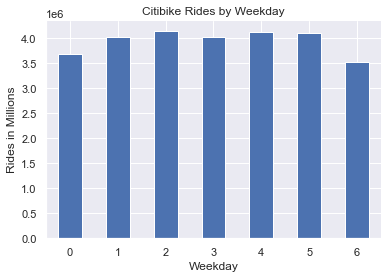

In [14]:
ax = weekday_rides.plot(kind='bar', 
                   title='Citibike Rides by Weekday', 
                   rot=0)

ax.set_xlabel("Weekday")
ax.set_ylabel("Rides in Millions")

#hide top and right spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

Saturday as denoted as 6 is the day with the lowest number of rides. Tuesday as denoted as 2 is the day with the most rides. 

Now let's look at hours.

In [15]:
ride_hours = combined_df.groupby(['started_at_hour']).size()

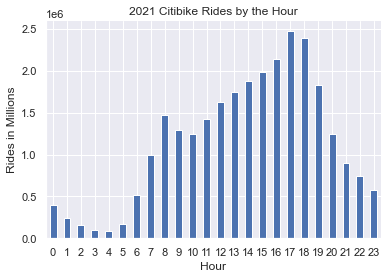

In [16]:
ax = ride_hours.plot(kind='bar', 
                   title='2021 Citibike Rides by the Hour', 
                   rot=0)

ax.set_xlabel("Hour")
ax.set_ylabel("Rides in Millions")

#hide top and right spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

Here we see that 4 AM is the hour with the least amount of rides. The peak time is 5 PM, which aligns with the usual commuter time back home. 

Given that Tuesday and Thursday are the days with the most rides, I would like to examine these days and analyze the hourly trends. 

In [17]:
day_hour_rides = combined_df.groupby(['started_at_weekday','started_at_hour']).size()
tuesday_rides = day_hour_rides[2]
thursday_rides = day_hour_rides[4]

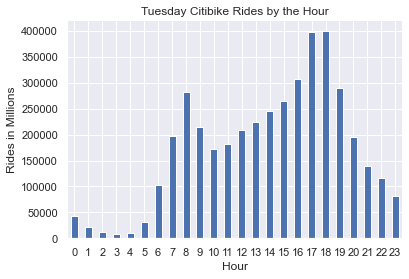

In [18]:
ax = tuesday_rides.plot(kind='bar', 
                   title='Tuesday Citibike Rides by the Hour', 
                   rot=0)

ax.set_xlabel("Hour")
ax.set_ylabel("Rides in Millions")

#hide top and right spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

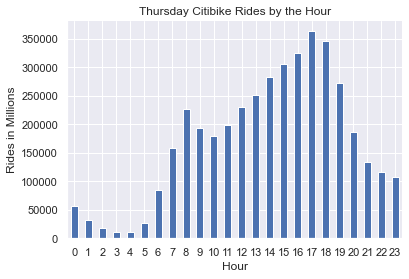

In [19]:
ax = thursday_rides.plot(kind='bar', 
                   title='Thursday Citibike Rides by the Hour', 
                   rot=0)

ax.set_xlabel("Hour")
ax.set_ylabel("Rides in Millions")

#hide top and right spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

Both days follow a similar pattern where 8 AM is the peak in the morning hours and the highest hours are between 5 to 6 PM.

## Spatial Analysis

Aim to analyze the expansion of stations and the stations where rides start the most.

In [20]:
#obtain the latitude and longitude for stations
latlongs = list(set(list(zip(combined_df['start_lat'], combined_df['start_lng']))))

In [21]:
#2021 locations to examine expansion over time
from folium import plugins
from folium.plugins import HeatMapWithTime

#mapping where trips start 
ny_coords = [40.738, -73.98]
folium_map = folium.Map(location=ny_coords, zoom_start=13, tiles="CartoDB dark_matter")


for lat,log in latlongs:
        folium.features.CircleMarker(
            [lat, log],
            radius=3,
            color='red',
            fill=True,
            fill_color='darkred',
            fill_opacity=0.6).add_to(folium_map)

folium_map

In [22]:
#save map as html file
folium_map.save("locations_2021.html")

In [23]:
#groupby starting latitude and starting longitude to get the number of rides that start at each station
location_rides = combined_df.groupby(['start_lat','start_lng']).size().reset_index()
location_rides = location_rides.rename(columns={0:'Rides'})
location_rides

,start_lat,start_lng,Rides
0,40.604017,-74.019709,12
1,40.604017,-74.019709,23
2,40.633385,-74.016562,1828
3,40.635679,-74.020005,2346
4,40.637033,-74.022141,2815
...,...,...,...
2898,40.879350,-73.885340,2479
2899,40.880294,-73.886065,14
2900,40.880294,-73.886065,613
2901,40.880295,-73.886065,26


In [24]:
#create the heatmap layer to add to map
location_rides_zip = zip(location_rides['start_lat'],location_rides['start_lng'], location_rides['Rides'])

hm_layer = HeatMap(list(location_rides_zip),
                   min_opacity=0.2,
                   radius=8,
                   blur=6, 
                 )

In [25]:
#heatmap of where most rides start in 2021
ny_coords = [40.738, -73.98]
folium_hmap = folium.Map(location=ny_coords, zoom_start=13, tiles="CartoDB dark_matter")


folium_hmap.add_child(hm_layer)
folium_hmap


In [26]:
#save map as html file
folium_hmap.save("hmap_2021.html")

In [27]:
#find the top 10 locations by name
top_locations = combined_df.groupby(['start_station_name']).size().sort_values(ascending=False)
print(top_locations.head(10))

start_station_name
W 21 St & 6 Ave             128788
E 17 St & Broadway          123770
1 Ave & E 68 St             113209
West St & Chambers St       109844
Broadway & W 25 St          102201
Cleveland Pl & Spring St    101082
Broadway & E 14 St           99692
6 Ave & W 33 St              96899
E 13 St & Avenue A           96590
West St & Liberty St         95507
dtype: int64


In [29]:
location1 = combined_df[['start_station_name','start_lat','start_lng']].drop_duplicates()

location1.to_csv (r'C:\Users\nicol\Documents\DS4A\Group Project\Citibike Data\citibike_locations_2021.csv', index = False, header=True)